In [592]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy import log10
import warnings

Parâmetros

In [597]:
#controlador = "PID"
alfa = 0.001               # horas

#cinética (saccharomyces)
mumax = 0.4               # 1/horas
Ks = 5                    # g/L
pH_ideal = 4.25
pH_max = 4.5
pH_min = 4
pH_ideal_range = pH_max - pH_min

#Fatores de conversão
Yxs = 0.03                # g/g
Ypx = 0.4/Yxs             # g/g
Yhx = 0.7                 # mol/g

#alimentação - substrato
Fs = 0.05                 # L/horas
Sf = 0.015                # g/L

#alimentação - base
FoH = 0.07                # L/horas
oHf = 10**(-1)            # moles/L

#condições iniciais
Xi = 0.015                # g/L
Pi = 0                    # g/L
Si = 0.005                # g/L
Vi = 100*1000             # L
pHi = 5

s1_0 = FoH
s2_0 = 0

IC_sim = [Xi, Pi, Si, Vi, 10**(-pHi), s1_0, s2_0, 0]

#tempo (residência)
t_final = 68         # horas

Funções, Controlador, Modelo e Simulador

In [598]:
# taxas de reação (Monod)
def mu_pH(H):
    return np.exp(-((pH_ideal - (-log10(max(10**(-14),H)))) / pH_ideal_range)**2)
def mu(S,H):
    return mumax*S/(Ks + S)*mu_pH(H)
def Rg(X,S,H):
    return mu(S,H)*X
def Rp(X,S,H):
    return Rg(X,S,H)*Ypx
def Rh(X,S,H):
    return Rg(X,S,H)*Yhx

# modelo
def modelo(t, y, controlador):
    X, P, S, V, H, s1, s2, Vb = y

    match controlador:
        case "off":
            ds1 = 0
            ds2 = 0
            B = 0
        case "step":
            ds1 = 0
            ds2 = 0
            B = FoH
        case "PID":
            ds1 = pH_ideal - (-log10(max(10**(-14),H)))
            ds2 = -1 / (alfa * Kd) * s2 + ds1 / (alfa * Kd)
            B = max(0, Kp / Ki * s1 - Kp / alfa * s2 + Kp * (1 / alfa + 1) * ds1)
        case "n-linear":
            #WIP
            ds1 = 0
            ds2 = 0
            B = 0
        case _:
            ds1 = 0
            ds2 = 0
            B = 0

    dVb = B
    dV = Fs + B
    dX = Rg(X,S,H) - dV*X/V
    dP = Rp(X,S,H) - dV*P/V
    dS = dV*(Sf - S)/V - Rg(X,S,H)/Yxs
    dH = Rh(X, S, H) - B*oHf/V - dV*max(10**(-14),H)/V

    return [dX, dP, dS, dV, dH, ds1, ds2, dVb]

def simulacao(t, controlador, IC):
    options = {
        'method': 'BDF',
        'rtol': 1e-6, 'atol': 1e-8
    }
    simulacao = solve_ivp(modelo, [0, t], IC, t_eval=np.linspace(0, t, 1000), args=(controlador,), **options)

    df = pd.DataFrame(simulacao.y.T, columns=["X", "P", "S", "V", "H", "s1", "s2", "Vb"])
    df["H"] = np.where(df["H"] <= 0, 10**(-14), df["H"])
    df["pH"] = -log10(df["H"])
    df["Tempo"] = simulacao.t
    df["B"] = np.where(simulacao.t == 0, 0, df["Vb"] / simulacao.t)

    return df

def graficos(df):
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    # Gráfico 1: X, P, S em função do tempo
    df.plot(
        x="Tempo",
        y=["X", "P", "S"],
        ylim = (0, 0.02),
        xlim = (0, t_final),
        grid=True,
        ax=ax[0],
        #title="X, P e S",
        xlabel="Horas",
        ylabel="g / L"
    )
    '''
    # Gráfico 2: V em função do tempo
    df.plot(
        x="Tempo",
        y="V",
        grid=True,
        ax=ax[1],
        #title="Volume",
        xlabel="Horas",
        ylabel="L"
    )
    '''
    # Gráfico 3: pH em função do tempo
    df.plot(
        x="Tempo",
        y="pH",
        ylim = (3, 5),
        xlim = (0, t_final),
        grid=True,
        ax=ax[1],
        #title="pH",
        xlabel="Horas",
        ylabel="pH"
    )
    # Gráfico 4: B em função do tempo
    df.plot(
        x="Tempo",
        y="B",
        ylim = 0,
        xlim = (0, t_final),
        grid=True,
        ax=ax[2],
        #title="pH",
        xlabel="Horas",
        ylabel="L / Horas"
    )

    ax[1].axhspan(pH_ideal - (pH_ideal_range/2), pH_ideal + (pH_ideal_range/2), facecolor='red', alpha=0.2, hatch='//', edgecolor='red')

    for ax_item in ax:
        for spine in ax_item.spines.values():
            spine.set_edgecolor((0, 0, 0, 0.1))  # RGBA color with alpha = 0.5
        
        ax_item.xaxis.label.set_alpha(0.5)
        ax_item.yaxis.label.set_alpha(0.5)
        for label in ax_item.get_xticklabels() + ax_item.get_yticklabels():
            label.set_alpha(0.5)

    
    
    plt.tight_layout()
    plt.show()

def otimizacao_IMC():
    IC = IC_sim
    t_atual = 0
    t_step = 1.0
    tol = 1e-5
    max_iter = 1000
    variaveis_anteriores = IC
    resultados = []
    tempos = []


    for i in range(max_iter):
        try:
            sol = solve_ivp(modelo, [t_atual, t_atual + t_step], variaveis_anteriores, args=("step",), method='BDF', rtol=1e-6, atol=1e-8);
            variaveis_atuais = sol.y[:, -1]
            if np.any(np.isnan(variaveis_atuais)) or np.any(np.isinf(variaveis_atuais)):
                raise ValueError("Numerical instability detected during integration.")
        except ValueError as e:
            print(f"Iteration {i}: {e}")
            break

        resultados.append(variaveis_atuais)
        tempos.append(sol.t[-1])
        t_atual += t_step

        delta = np.max(np.abs((variaveis_atuais[:3] - variaveis_anteriores[:3]) / (np.array(variaveis_anteriores[:3]) + 1e-10)))
        if delta < tol:
            break

    variaveis_anteriores = variaveis_atuais


    resultados = np.array(resultados).T
    ee = pd.DataFrame(resultados.T, columns=["X", "P", "S", "V", "H", "s1", "s2", "Vb"])
    ee["H"] = np.where(ee["H"] <= 0, 10**(-14), ee["H"])
    ee["pH"] = -log10(ee["H"])
    ee["Tempo"] = tempos
    ee["B"] = np.where(tempos == 0, 0, ee["Vb"] / tempos)

    IC_EE = ee.iloc[-1].to_list()  # Extract the last row values for X, P, S, V, H, s1, s2, Vb
    IC_IMC = [IC_EE[0], IC_EE[1], IC_EE[2], IC_EE[3], 10**(-IC_EE[8]), FoH, 0, 0]
    t_fin = 3 #IC_EE[9]
    simulacao_df = simulacao(t_fin, "step", IC_IMC)

    delta_y = simulacao_df['pH'].iloc[-1] - simulacao_df['pH'].iloc[0] #ultima medida de pH menos primeira medida de pH
    delta_u = FoH - 0 #tamnaho step

    pH_353 = simulacao_df['pH'].iloc[0] + 0.353*delta_y # pH a 35,3 % dp EE
    t_353 = simulacao_df.loc[(simulacao_df['pH'] - pH_353).abs().idxmin(), 'Tempo'] #tempo nessa estágio

    pH_853 = simulacao_df['pH'].iloc[0] + 0.853*delta_y # pH a 85,3 % dp EE
    t_853 = simulacao_df.loc[(simulacao_df['pH'] - pH_853).abs().idxmin(), 'Tempo'] #tempo nesse estágio

    K = delta_y / delta_u
    tau = 0.67 * (t_853 - t_353)
    tau_c = tau / 10

    Kp_o = float(abs((2 * tau + alfa) / (2 * K * (tau_c + alfa))))
    Ki_o = float(tau + (alfa / 2))
    Kd_o = float(tau * alfa / (2 * tau + alfa))

    
    warnings.simplefilter("ignore")

    return [Kp_o,Ki_o,Kd_o]


Simulacao sem controle (sem fluxo de base)

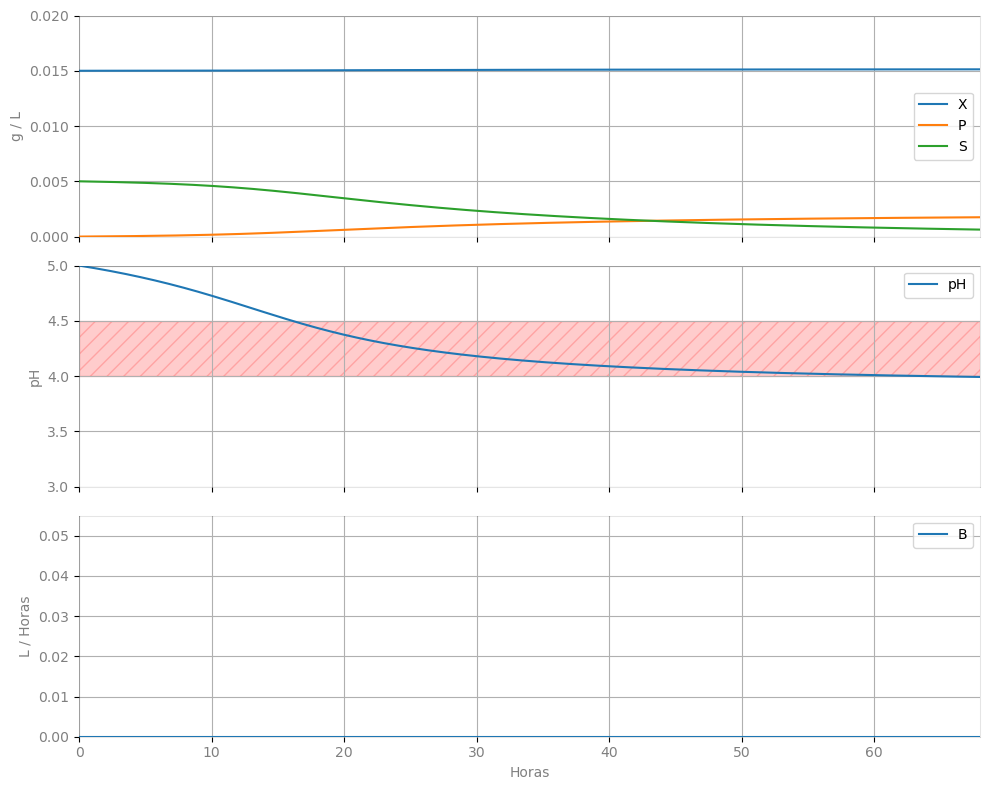

In [599]:
sim_1 = simulacao(t_final, 'off', IC_sim)
graficos(sim_1)

simulacao com controle (PID otimizado IMC)

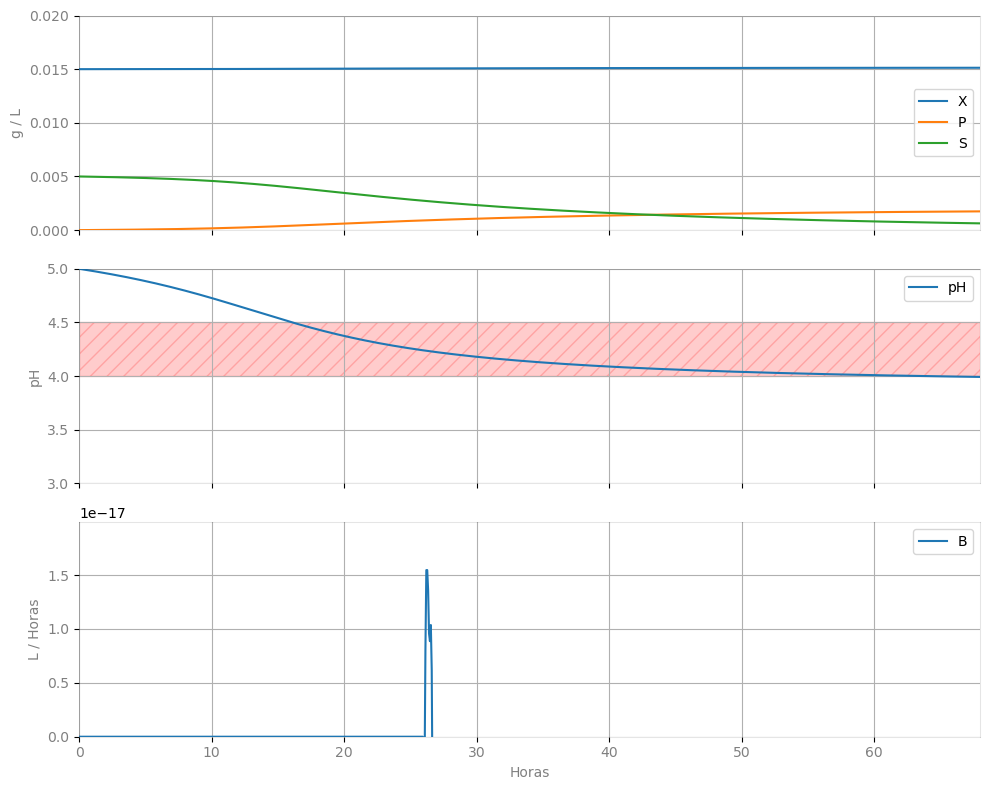

In [600]:
vetor_K = otimizacao_IMC()

Kp = vetor_K[0]
Ki = vetor_K[1]
Kd = vetor_K[2]

sim_PID = simulacao(t_final, 'PID', IC_sim)
graficos(sim_PID)